### Обучить сиамскую сеть для верификации лиц на датасете LFW

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
import imageio
import tensorflow as tf
import tensorflow_datasets as tfds

# tf.debugging.set_log_device_placement(True)
%matplotlib inline

In [3]:
train, info = tfds.load('lfw', as_supervised=True, with_info=True, download=True)

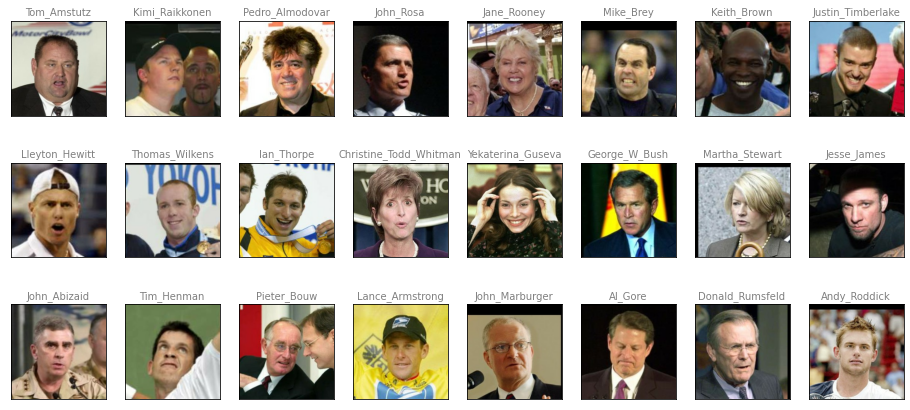

In [4]:
samples = [(x[0], x[1]) for x in iter(train['train'].take(24))]
fig = plt.figure(figsize=(16,10))
for i in range(len(samples)):
    ax = fig.add_subplot(4, 8, i+1)
    ax.imshow(samples[i][1])
    plt.title(samples[i][0].numpy().decode("utf-8"), color='grey', fontsize=10)
    plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
len(train['train']), train['train'].take(1)

(13233,
 <TakeDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>)

In [6]:
# There is not enought memory to use GPU, hence, change proc. unit for this block
with tf.device('/CPU:0'):
    samples = [(x[0], x[1]) for x in iter(train['train'].take(len(train['train'])))]
    x_train, y_train = [], []
    for i in range(len(samples)):
        x_train.append(tf.image.resize(samples[i][1], size=(54, 54)))
        y_train.append(samples[i][0].numpy().decode("utf-8"))

    x_train = (np.array(x_train).astype(np.float32) - 127.5) / 127.5
    y_train = np.array(y_train)
    x_train.shape, y_train.shape

In [7]:
def plot_pics(samples):
    fig = plt.figure(figsize=(16, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow((samples[j, ...].reshape(54, 54, 3) * 127.5 + 127.5).astype('uint8'))
        plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(3, (3, 3), padding='valid', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [12]:
# Network Parameters
INPUT_DIM = 300
NUM_EPOCHS = 100
HALF_BATCH_SIZE = 32
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 3e-4

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

0it [00:00, ?it/s]

[Step  0] D Loss: 0.2167; G Loss: 0.7146


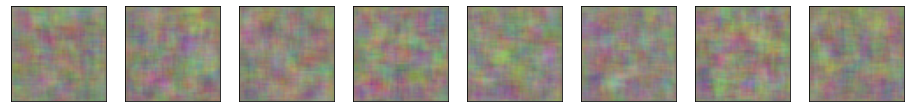

1000it [05:01,  3.40it/s]

[Step 1000] D Loss: 0.0836; G Loss: 2.9561


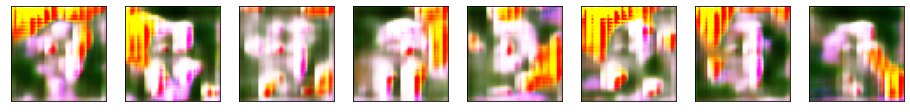

2000it [09:58,  3.34it/s]

[Step 2000] D Loss: 0.3966; G Loss: 8.2965


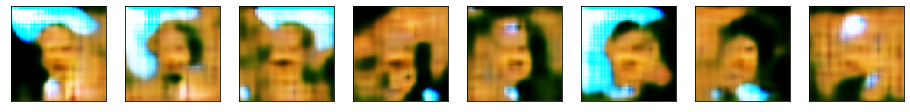

3000it [14:56,  3.38it/s]

[Step 3000] D Loss: 0.4510; G Loss: 4.8862


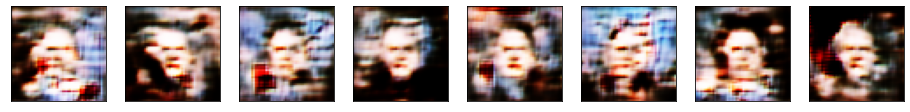

4000it [24:20,  2.71it/s]

[Step 4000] D Loss: 0.1880; G Loss: 5.7241


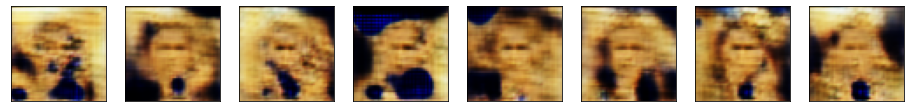

5000it [29:01,  3.39it/s]

[Step 5000] D Loss: 0.1800; G Loss: 4.5005


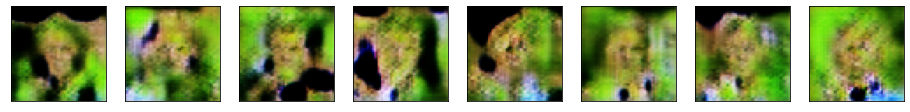

6000it [33:41,  3.58it/s]

[Step 6000] D Loss: 0.9675; G Loss: 1.1279


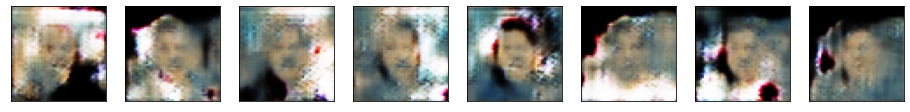

7000it [38:18,  3.61it/s]

[Step 7000] D Loss: 0.1663; G Loss: 4.7375


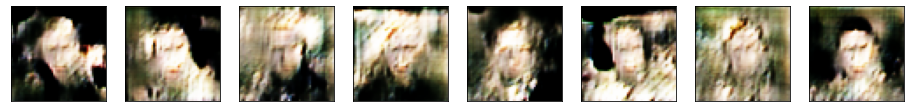

8000it [42:58,  3.58it/s]

[Step 8000] D Loss: 0.1334; G Loss: 4.5106


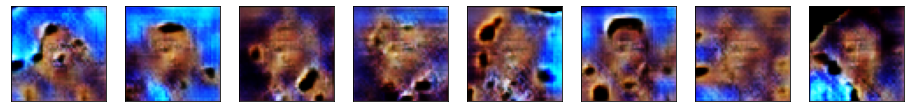

9000it [47:37,  3.60it/s]

[Step 9000] D Loss: 0.3370; G Loss: 1.1529


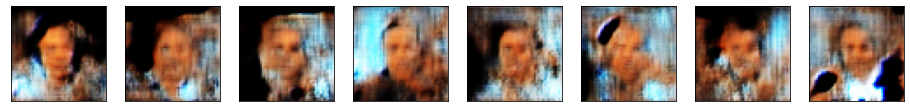

10000it [52:20,  3.58it/s]

[Step 10000] D Loss: 0.2918; G Loss: 3.9819


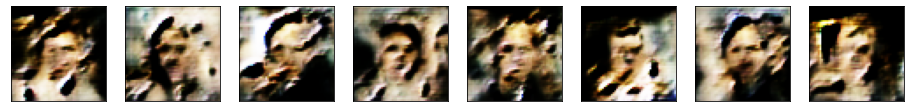

11000it [57:02,  3.56it/s]

[Step 11000] D Loss: 1.3067; G Loss: 2.4380


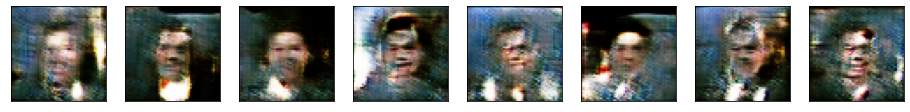

12000it [1:01:44,  3.59it/s]

[Step 12000] D Loss: 0.1827; G Loss: 2.9730


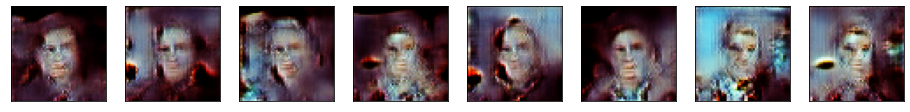

13000it [1:06:26,  3.57it/s]

[Step 13000] D Loss: 0.4290; G Loss: 1.7613


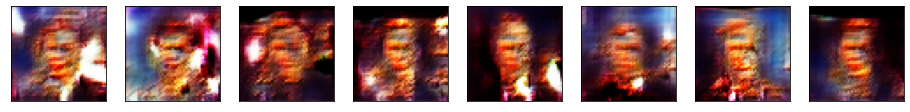

14000it [1:11:10,  3.56it/s]

[Step 14000] D Loss: 0.3914; G Loss: 2.3005


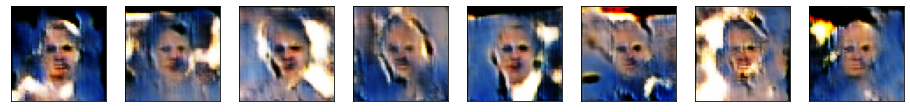

15000it [1:15:50,  3.66it/s]

[Step 15000] D Loss: 0.0326; G Loss: 4.0709


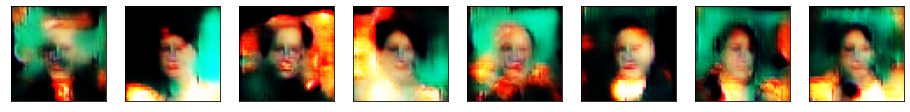

16000it [1:20:31,  3.57it/s]

[Step 16000] D Loss: 0.3706; G Loss: 3.6427


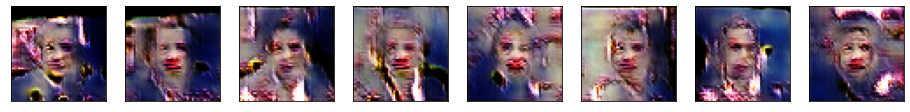

17000it [1:25:13,  3.56it/s]

[Step 17000] D Loss: 0.7007; G Loss: 3.0279


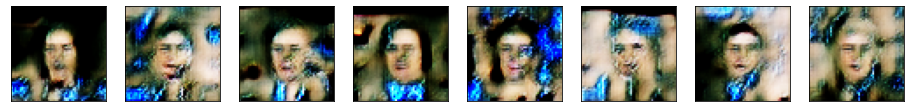

18000it [1:29:54,  3.52it/s]

[Step 18000] D Loss: 0.3529; G Loss: 2.3365


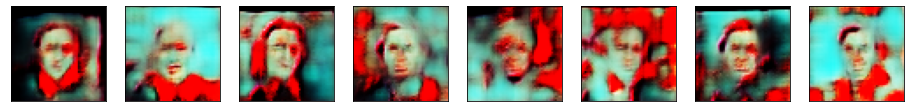

19000it [1:34:38,  3.17it/s]

[Step 19000] D Loss: 0.2160; G Loss: 2.7982


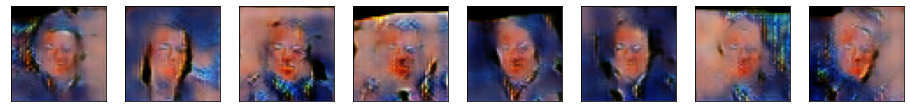

20000it [1:39:18,  3.79it/s]

[Step 20000] D Loss: 0.5056; G Loss: 3.1444


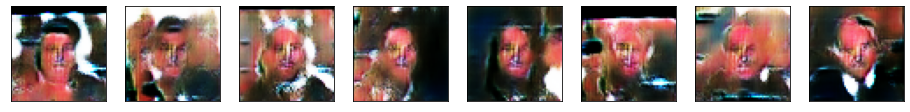

21000it [1:43:45,  3.58it/s]

[Step 21000] D Loss: 0.2956; G Loss: 2.7394


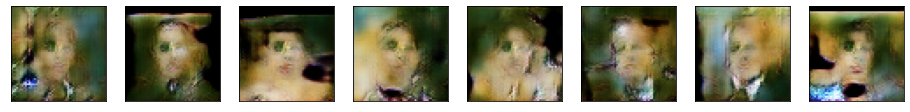

22000it [1:48:21,  3.75it/s]

[Step 22000] D Loss: 0.5006; G Loss: 2.9961


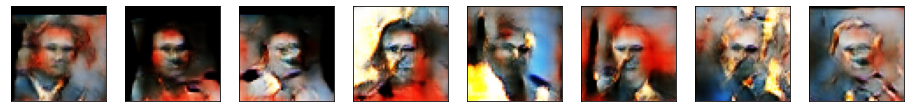

23000it [1:52:49,  3.48it/s]

[Step 23000] D Loss: 0.3970; G Loss: 1.9330


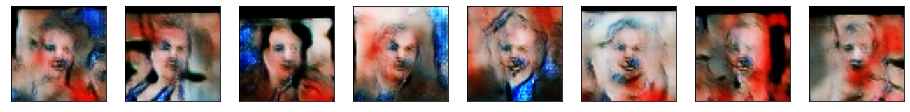

24000it [1:57:15,  3.80it/s]

[Step 24000] D Loss: 0.2788; G Loss: 3.6903


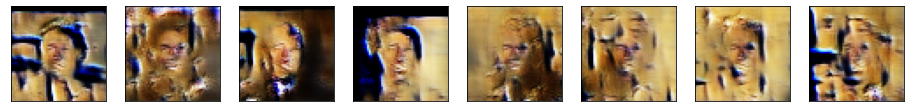

25000it [2:01:40,  3.78it/s]

[Step 25000] D Loss: 0.3807; G Loss: 2.6977


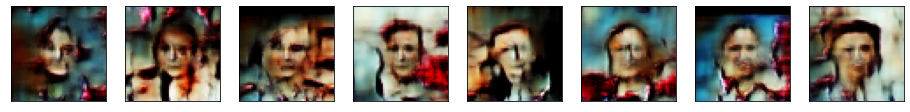

26000it [2:06:05,  3.76it/s]

[Step 26000] D Loss: 0.3627; G Loss: 2.6053


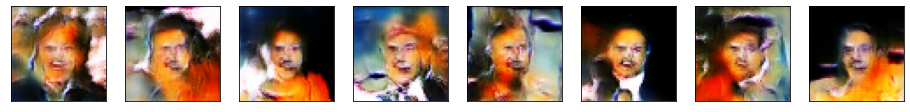

27000it [2:10:30,  3.79it/s]

[Step 27000] D Loss: 0.1881; G Loss: 4.0156


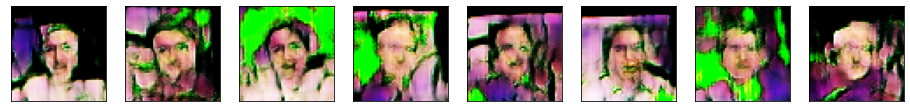

28000it [2:14:54,  3.78it/s]

[Step 28000] D Loss: 0.7244; G Loss: 2.4822


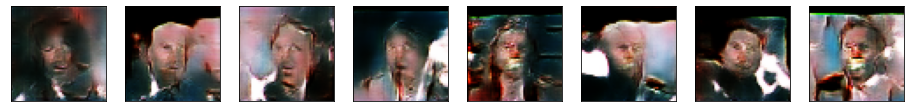

29000it [2:19:19,  3.79it/s]

[Step 29000] D Loss: 0.2823; G Loss: 2.6730


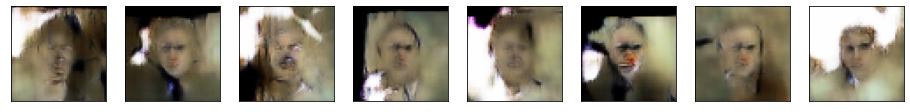

30000it [2:23:44,  3.81it/s]

[Step 30000] D Loss: 0.5577; G Loss: 2.3760


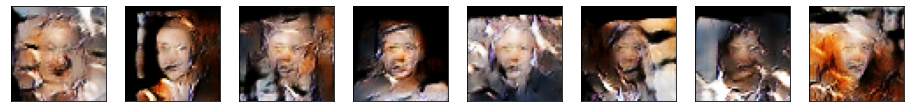

31000it [2:28:08,  3.80it/s]

[Step 31000] D Loss: 0.5163; G Loss: 1.4355


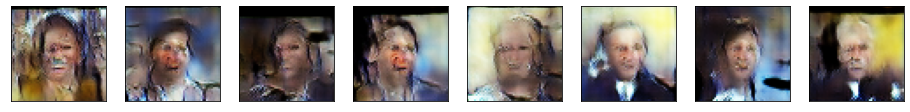

32000it [2:32:34,  3.77it/s]

[Step 32000] D Loss: 0.5647; G Loss: 1.1867


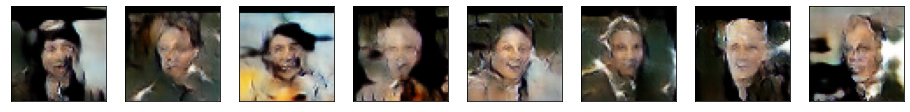

33000it [2:36:59,  3.79it/s]

[Step 33000] D Loss: 0.5951; G Loss: 1.9968


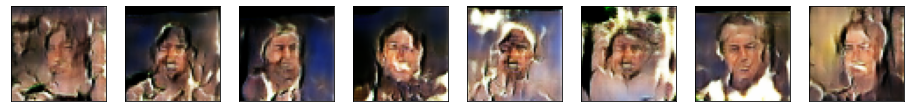

34000it [2:41:24,  3.80it/s]

[Step 34000] D Loss: 0.5945; G Loss: 2.7275


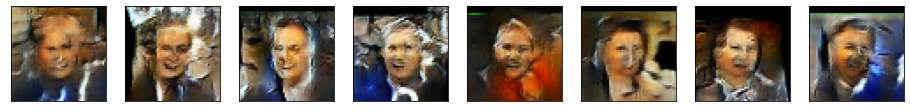

35000it [2:45:50,  3.76it/s]

[Step 35000] D Loss: 0.1652; G Loss: 3.1654


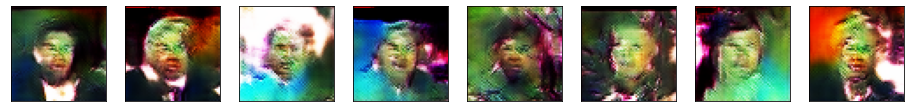

36000it [2:50:17,  3.78it/s]

[Step 36000] D Loss: 0.1841; G Loss: 3.5385


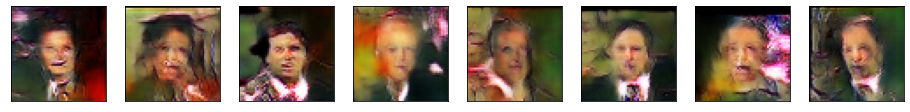

37000it [2:54:41,  3.79it/s]

[Step 37000] D Loss: 0.2794; G Loss: 3.1344


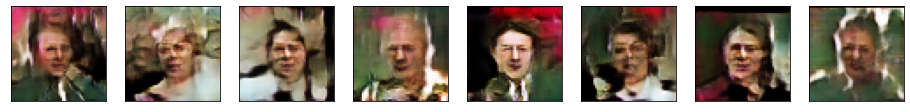

38000it [2:59:07,  3.77it/s]

[Step 38000] D Loss: 0.4972; G Loss: 1.6567


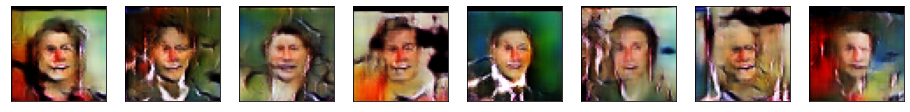

39000it [3:03:32,  3.79it/s]

[Step 39000] D Loss: 0.5214; G Loss: 1.7446


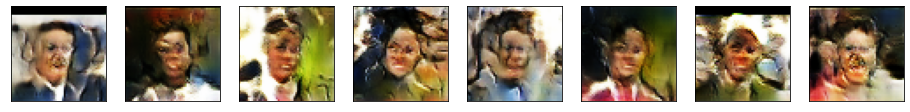

40000it [3:08:03,  3.80it/s]

[Step 40000] D Loss: 0.3698; G Loss: 1.5765


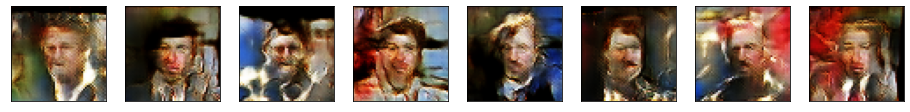

41000it [3:12:28,  3.78it/s]

[Step 41000] D Loss: 0.6921; G Loss: 1.4261


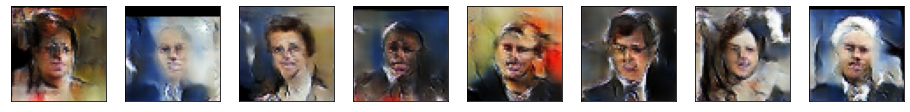

41353it [3:14:02,  3.55it/s]

Wall time: 3h 14min 3s


In [14]:
%%time
for step, true_images in tqdm(enumerate(train_ds)):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)